# Dictionary Learning and Sparse Coding
## Application to image restoration

In this notebook we will analyse a dictionary learning procedure to address image processing (and in particular image restoration) tasks. We will rely on <tt> sklearn </tt> libraries.


## Goal of this notebook

We will take into account problems of increasing complexity
<ol>
    <li> denoise grey level images </li>
    <li> denoise color images</li>
    <li> fill holes (inpainting) </li>
    
</ol>

In [1]:
# LOAD LIBRARIES

from time import time
from math import floor, sqrt, log10

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
from skimage import data, color, img_as_float,  img_as_ubyte, filters, feature, util,io
from skimage.transform import rescale

from sklearn.decomposition import MiniBatchDictionaryLearning, DictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

%matplotlib inline
from IPython.display import HTML, display

# 1. Image denoising - grey level images
We first consider images artificially corrupted by noise to be able to estimate the "quality" of the reconstruction. 
<ul>
<li> Load an image </li>
<li> Downsample it if it's too big </li>
<li> Add some Gaussian noise (try with different amount) </li>
</ul>

In [2]:
#Loading images
image = io.imread('images/lena.png')
image = img_as_float( (image))

# It may be useful to downsample for higher speed (depending on the size
# of the image).
image = rescale(image,0.5)

height, width = image.shape

In [3]:
# Corrupt the image by adding Gaussian noise
print('Corrupting image with additive Gaussian noise...')

mean =0
var = 0.075 #try with different amount of noise
noise = np.random.normal(mean, var, image.shape)
distorted = image + noise


Corrupting image with additive Gaussian noise...


In [4]:
# Display the distorted image and the difference from original one for reference
# NOTICE ARTIFICAL NOISE (I DO HAVE THE ORIGINAL IMAGES!)

def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(5, 3.3))
    plt.subplot(121)
   
    plt.title('Image (%d,%d) size' % (image.shape[0] , image.shape[1]) )
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.subplot(122)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference ** 2)))
    plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)


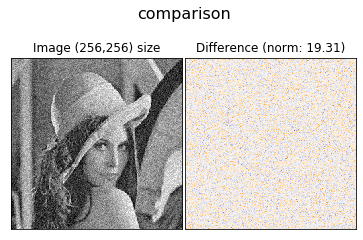

In [5]:
show_with_diff(distorted,image,'comparison')


## 1.1 Dictionary learning phase

Now we learn a dictionary of adaptive patches from an image. We consider the original, undistorted image as a reference of this step. We will adopt k-SVD as it is efficient and appropriate for image denoising.

In the following snippet we will take care of the following steps:
<ul>
    <li> Extract  reference WxW patches from the image (see function <tt>extract_patches_2d</tt>, then normalize them (mean 0 variance 1) </li>
<li> Learn a dictionary of size K by applying K-SVD </li>
</ul>

Notice: here i suggest <tt>MiniBatchDictionaryLearning</tt> which is faster, but less accurate version, of dictionary learning. The functions parameters are the same, if you want to try the more accurate simply substitute with the call <tt>DictionaryLearning</tt>

In [6]:
# set the parameters
patch_size=(7, 7) #patch size
K=200 #dictionary size

In [7]:
# Extract all reference patches from the image 
print('Extracting reference patches...')
data = extract_patches_2d(image, patch_size) # Consult the function help and then ADD PARAMETERS HERE )
data = data.reshape(data.shape[0], -1) 
print('The size of the data matrix is: n_samples = %d ; n_features = %d '%
      (data.shape[0],data.shape[1]))

# normalize each unrolled patch (row of the data matrix)) : mean=0 std=1
data -= np.mean(data, axis=0)
data /= np.std(data, axis=0)

Extracting reference patches...
The size of the data matrix is: n_samples = 62500 ; n_features = 49 


Learning the dictionary...


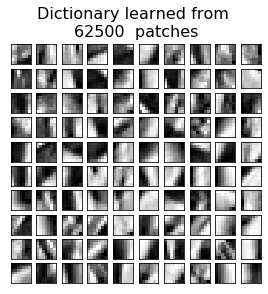

In [8]:
# LEARN THE DICTIONARY

print('Learning the dictionary...')
# create the object (nothing to add here, but check the parameters and make sense out of them)
dico = MiniBatchDictionaryLearning(n_components=K, alpha=1, n_iter=500,transform_algorithm='omp') 
# compute the dictionary
atoms = dico.fit(data).components_

# VISUALIZE THE LEARNT ATOMS    
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(atoms[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from \n' +
             '%d  patches' % (len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

## 1.2 Sparse coding: a dictionary based denoising

We take the noisy image, devide it in patches of the same size as above, approximate them in a sparse way as a linear combination of few atoms from the learnt dictionary and recombine the image. Use the Orthogonal Matching Pursuit (OMP) sparse linear approximation

In [9]:
non_zero_c = 2 # set the number of non zero coefficients 
               # to use in the OMP reconstruction
               # try other values (1, 2, 3, 4..)

In [10]:
# extract noisy patches 
print('Extracting patches from the image ... ')
data = extract_patches_2d(distorted, patch_size)
data = data.reshape(data.shape[0], -1) 
intercept = np.mean(data, axis=0) 
data -= intercept

# reconstruct the patches as a sparse linear approximation (OMP)
print('Reconstruct denoised approximations... ')
dico.set_params(\
                transform_algorithm = 'omp',\
                **{'transform_n_nonzero_coefs': non_zero_c}\
                ) # -- FILL HERE --
code = dico.transform(data) # --FILL HERE-- )

print (data.shape)
print (code.shape)
print (atoms.shape)

patches = np.dot(code, atoms)# compute the dot product between the code and the dictionary atoms

print (patches.shape)
# recombine the image

patches += intercept #denormalize
patches = patches.reshape(len(data), *patch_size)
reconstruction = reconstruct_from_patches_2d(patches, (height, width))# --FILL HERE-- )



Extracting patches from the image ... 
Reconstruct denoised approximations... 
(62500, 49)
(62500, 200)
(200, 49)
(62500, 49)


## 1.3 Evaluate the quality of the reconstruction
Here we  evaluate the peak signal-to-noise ratio (PSNR) of the denoised image w.r.t the original one and visualize the results

In [11]:
def psnr(original_image, approximation_image):
    return 20*log10(np.amax(original_image)) - 10*log10(pow(np.linalg.norm(original_image - approximation_image), 2)
                                                        / approximation_image.size)


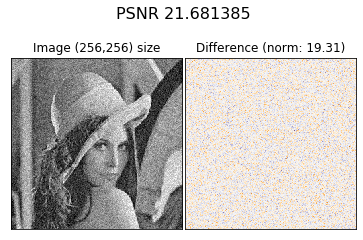

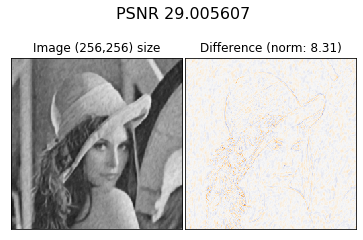

In [12]:
#compare the corrupted image with the original noise-less image
quality=psnr(image,distorted)
show_with_diff(distorted, image, 'PSNR %f' %quality)
plt.show()

#compare the denoised image with the original noise-less image
quality=psnr(image,reconstruction)
show_with_diff(reconstruction, image, 'PSNR %f' %quality)
plt.show()

## 1.4 Analysis of the results 
Try with different values of the following parameters and add here your evaluation on the results obtained:

The following observations are made with respect to the plots produced by the analysis code. Notice that I plotted also the size of the dictionary vs PSNR, in order to have a better understanding of that case.
<ul>
<li> <b> Different size of the dictionary K: </b> 
    First of all, we have to underline that the plot "size of dictionary K vs PSNR" has been performed by keeping a fixed number of non-zero components and a fixed patch size; in our case, n_nonzero_c=2 and patch_size=(7, 7).
    From the plot we can observe that, for small values of K we obtain low values for the PSNR, whereas by increasing the value of K we also increase the PSNR in a quite fast way until we reach the value K=200, from which the growth of the curve starts to slow down until it stabilizes for very large values of K. This behaviour can be motivated in the following way: the larger our dictionary, the better would be our approximation of the input patches which we are coded through the dictionary, because if we look for a small number of non-zero components (n_nonzero=2 in our case) we do so in higher and higher dimensions for the dictionary and therefore we are less bound to small details such as the gaussian noise and more able to approximate better the main features of the image, but we cannot improve the PSNR forever, because the best coefficients for each coded patch in the matrix $U$ could already have been found for smaller values of K. We may therefore over-represent each patch to obtain a poor improvement in terms of denoising. In other words, from a certain point onwards we cannot be more expressive with larger values of K. It seems therefore that the choice of setting K=200 is a good one, because it is exactly the value from which it is pointless to increase more the dimensionality of the dictionary, as we can see from the plot. Stopping early in increasing the dictionary size may be done in order to save memory space and computational time. </li>
<li> <b> Different size of the atoms patch_size: </b> First of all, we have to underline that the plot "size of the patch vs PSNR" has been performed by keeping a fixed number of non-zero components and a fixed dictionary size; in our case, n_nonzero_c=2 and K=200. From the plot we can observe that, for small patch sizes, we obtain very low values of the PSNR, for instance when the patch side equals 2 we obtain PSNR=22. If we then increase the value of the patch side, the PSNR increases quite fast until it reaches a peak which corresponds approximately to a patch side equal to 6; after that peak, if we keep increasing the patch side, then the PSNR keeps decreasing, but with less speed than the growth rate. This behaviour can be motivated in the following way: at the beginning of the dictionary learning procedure, we extract patches from the image and we use them as a training set to learn our dictionary. Therefore, the atoms contained in our dictionary will be based on the knowledge we retrieved from the training image (the one without noise). We can guess that such knowledge may be more "global" or more "local" depending on the patch size. In the code provided in the previous cells, we perform again the patch extraction with the same size on the noisy test image in order to obtain test samples to assess the denoising procedure. Starting from these facts, we can understand that if the patch is big, then we are adopting a higher point of view to build our model, whereas if we use a small patch then we may include in the model small details of the image, such as noisy points, and therefore, that a good value for the patch side should be one neither too high nor too low. In fact, a too big patch side should give as output a heavily blurred image, like the one we would obtain by adopting a gaussian filter with a large $\sigma$, because very large patches cause a massive "averaging effect" when performing the dot product $D \cdot u$, whereas a too small patch should return exactly the same noisy test image, because we are keeping all the possible information about the tiny details with more "local" patches and therefore the approximation patches obtained from the dot product $D \cdot u$ will not be very different from the ones of the noisy image (we recall that for both images we retrieved patches of the same size, therefore a dictionary trained on fine details should return, intuitively, the same fine details of the test image). To be effective in the denoising procedure, we should choose a good patch size; by observing the plot, we can guess that the choice of setting the patch side to 7 probably was good in our case, because it is close to the best possible choice, which is 6.   </li>
<li> <b> Different level of sparsity non_zero_c: </b> First of all, we have to underline that the plot "number of non-zero coefficients vs PSNR" has been performed by keeping a fixed patch size and a fixed dictionary size; in our case, patch_size=(7, 7) and K=200, which we recall to be the optimal choices for the images under analysis, as pointed out in the previous comments. From the plot we can observe that, for small numbers of non-zero coefficients considered in each vector $u$, the resulting PSNR is either at or close to its maximum, which is located approximately at n_nonzero_c=3, whereas if we decrease the number of non-zero coefficients for each $u$ then the PSNR keeps decreasing until we reach a global minimum. This behaviour can be motivated in the following way: since in our case we are using optimal choices for the patch size and K, then the n_nonzero_c parameter alone will control how much our solution will be approximated with respect to the original non-noisy image. In fact, when we transform the patches of the noisy test image, we obtain the corresponding patches in the feature space, which are stored in the variable "code". The approximated patches are obtained with the dot product $D \cdot u$, in fact we recall that such dot product is used to go back in the data space from the feature space; when we use a small number of non-zero components of each vector $u$, all the coded patches will have many zero values in the produced matrix $U$ and therefore the level of local detail effectively considered will be less with respect to the original non-noisy image, because for each patch we only keep the few most important components through the orthogonal matching pursuit, whereas if instead we increase the number of non-zero components then we will resort to a over-descriptive representation of our signal for each patch used, and this will retain exactly the noisy test image. Therefore, we can conclude that the smaller the value of the number of non-zero coefficients, the more effective our denoising procedure will be, provided that the size of the dictionary and of the patches are reasonable: for what concerns the dictionary, we should always map the data in higher dimensions than $d$ in the $X$ matrix, for what concerns the patches we should not adopt a too low or too high patch size, in order not to fall in the same problems we have seen in the comments to the other plots.</li>
</ul>

For an in-depth analysis you may produce the following plots (recommended)
<ul>
<li>number of non-zero coefficients vs PSNR</li>
<li>patch size vs PSNR</li>
</ul>
Add your analysis code in the cell below

In [13]:
import warnings
warnings.filterwarnings("ignore")
def compute_psnr(image, distorted, K, patch_size, n_nonzero_coef, height, width, refit=True):
    data = extract_patches_2d(image, patch_size) 
    data = data.reshape(data.shape[0], -1) 
    data -= np.mean(data, axis=0)
    data /= np.std(data, axis=0)
    
    dico = MiniBatchDictionaryLearning(n_components=K, alpha=1, n_iter=500,transform_algorithm='omp') 
    atoms = dico.fit(data).components_
    
    data = extract_patches_2d(distorted, patch_size)
    data = data.reshape(data.shape[0], -1) 
    intercept = np.mean(data, axis=0) 
    data -= intercept
    
    dico.set_params(\
                transform_algorithm = 'omp',\
                **{'transform_n_nonzero_coefs': n_nonzero_coef}\
                ) 
    code = dico.transform(data) 
    patches = np.dot(code, atoms)
    patches += intercept 
    patches = patches.reshape(len(data), *patch_size)
    reconstruction = reconstruct_from_patches_2d(patches, (height, width))
    quality=psnr(image,reconstruction)
    return quality

patch_sizes = list(range(2, 21, 2))
nums_coefs = list(range(1, 31))
K_values = [10, 20, 30, 70, 100, 120, 150, 170, 200, 220, 250, 300, 320, 350, 400, 420, 450, 500, 520, 550]
psnr_results_coefs = []
psnr_results_patches = []
psnr_results_K = []
K=200 
patch_size=(7, 7) 
non_zero_c = 2
for n_nonzero_coef in nums_coefs:
    psnr_results_coefs.append(compute_psnr(image, distorted, K, patch_size, n_nonzero_coef, height, width))
    
for patch_s in patch_sizes:
    psnr_results_patches.append(compute_psnr(image, distorted, K, (patch_s, patch_s), non_zero_c, height, width))

for k in K_values:
    psnr_results_K.append(compute_psnr(image, distorted, k, patch_size, non_zero_c, height, width))
   



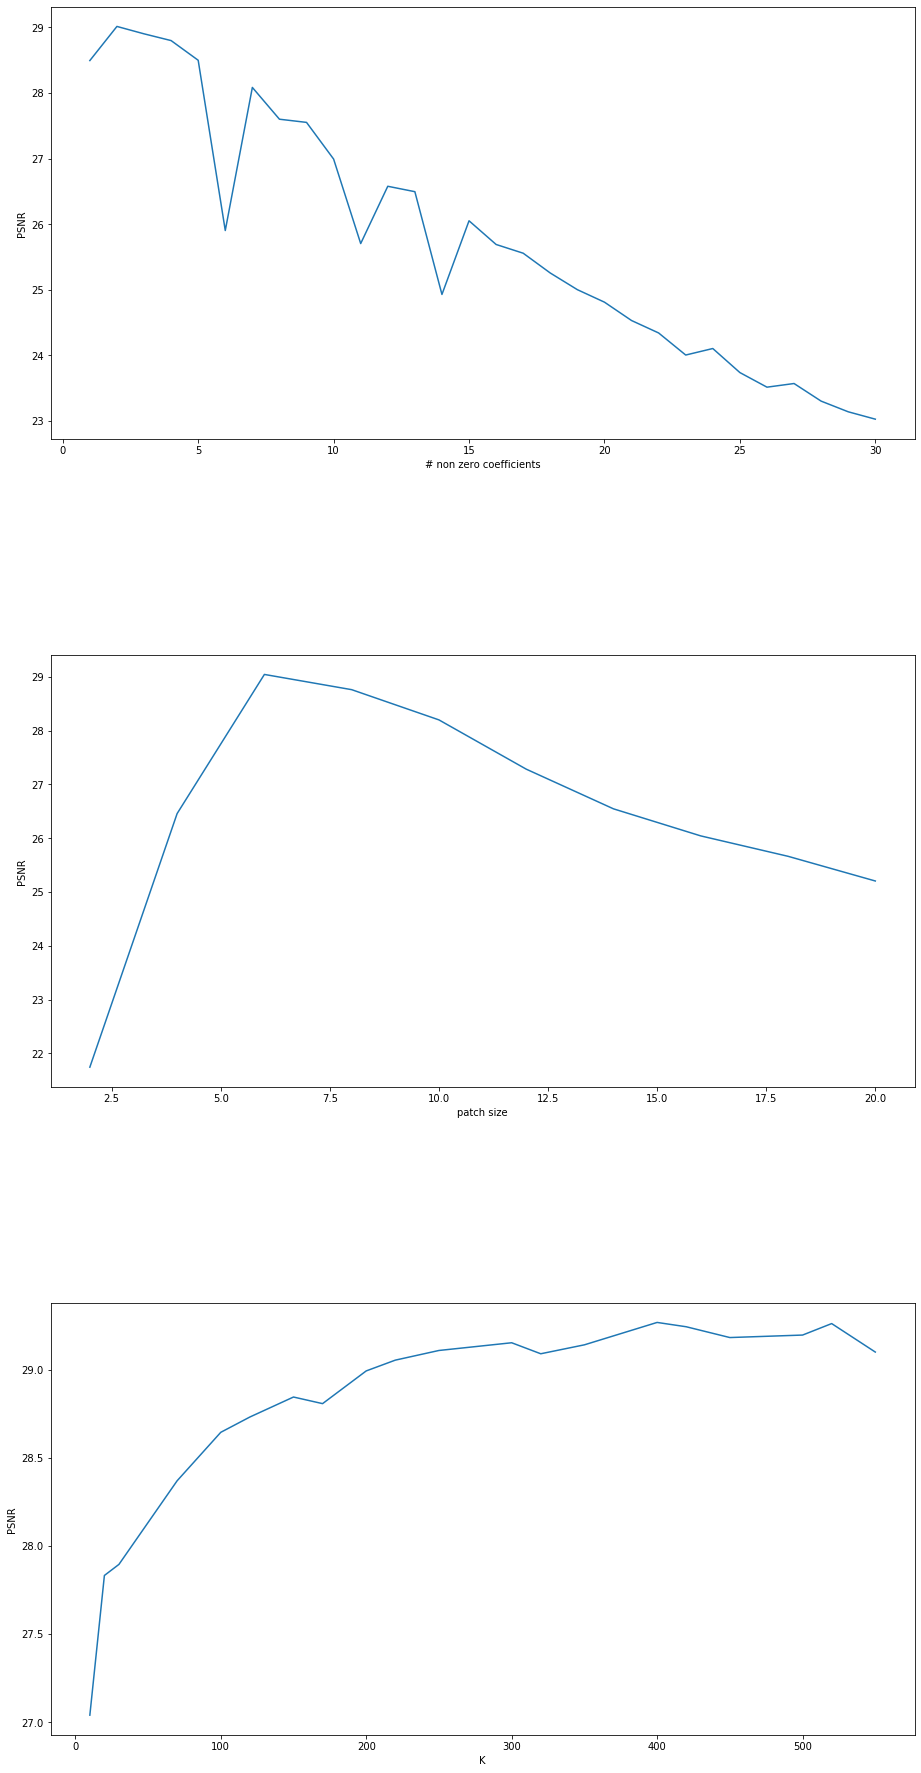

In [14]:
fig, axs = plt.subplots(3, 1)
axis_iterator = iter(axs)
curr_axis = next(axis_iterator)
curr_axis.set_xlabel("# non zero coefficients")
curr_axis.set_ylabel("PSNR")
curr_axis.plot(nums_coefs, psnr_results_coefs)
curr_axis = next(axis_iterator)
curr_axis.set_xlabel("patch size")
curr_axis.set_ylabel("PSNR")
curr_axis.plot(patch_sizes, psnr_results_patches)
curr_axis = next(axis_iterator)
curr_axis.set_xlabel("K")
curr_axis.set_ylabel("PSNR")
curr_axis.plot(K_values, psnr_results_K)
fig.subplots_adjust(top=3,bottom=-3,left=-1,right=1, hspace=0.5, wspace=0.5)

# 2. How meaningful is the dictionary for different images?

So far we have addressed a toy problem which is not applicable in practice (why)?
We now take a step forward and try to apply the same precomputed dictionary on a different image of the same type.

We first start by chosing another image and adding synthetic Gaussian noise as we did before

Answer to the question reported in the previous cell:

The toy problem that we addressed so far is not applicable in practice, because in real situations we don't have the true image, but only the version with noise. Denoising an image by using as training data the same image without noise is an easy task, and from the machine learning point of view could also lead us to "overfit" the denoising results to a particular image, in the sense that the denoising results may not be good for more than one image. To improve this situation in general, we could extend the algorithms seen so far to use as training set several images without noise having the same type of "Lena.png". In this case, we will surely generalize better to multiple images of the same type for what concerns the denoising results.

In [15]:
test = io.imread('images/Barbara.png')
test = rescale(test,0.5)

In [16]:
# NEW IMAGE  

test = img_as_float( (test))
height, width = test.shape

# Corrupt the image by adding Gaussian noise

# FILL HERE
mean =0
var = 0.075 
noise = np.random.normal(mean, var, test.shape)
distorted_test = test + noise


In [17]:
# extract noisy patches 
K=200 
patch_size=(7, 7) 
non_zero_c = 2
print('Extracting noisy patches... ')

data = extract_patches_2d(distorted_test, patch_size)
data = data.reshape(data.shape[0], -1) 
intercept = np.mean(data, axis=0) 
data -= intercept #must the intercept be the same as the training set?

# reconstruct the patches as a sparse linear approximation (OMP)
print('Reconstruct denoised approximations... ')
dico.set_params(\
                transform_algorithm = 'omp',\
                **{'transform_n_nonzero_coefs': non_zero_c}\
                ) # -- FILL HERE --
code = dico.transform(data) # --FILL HERE-- )
patches = np.dot(code, atoms)# compute the dot product between the code and the dictionary atoms

# recombine the image

patches += intercept #denormalize
patches = patches.reshape(len(data), *patch_size)
reconstruction_test = reconstruct_from_patches_2d(patches, (height, width))# --FILL HERE-- )

#this part is doubled in the notebook, why?


Extracting noisy patches... 
Reconstruct denoised approximations... 


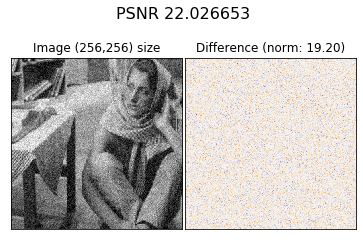

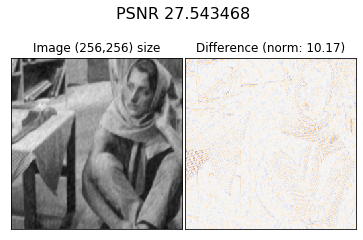

In [18]:
#compare the corrupted image with the original noise-less image
quality=psnr(test,distorted_test)
show_with_diff(distorted_test, test, 'PSNR %f' %quality)
plt.show()

#compare the denoised image with the original noise-less image
quality=psnr(test,reconstruction_test)
show_with_diff(reconstruction_test, test, 'PSNR %f' %quality)
plt.show()

The above reconstruction has an uneven quality (see the difference image). Can you imagine why? If you have an intuition on the motivations you may add it here.

One observation that can be made is that the norm of the difference image is greater than the case in which we computed the same quantity with respect to "Lena.png" and its approximated version produced from the noisy "Lena.png"; something similar happens for the PSNR, which instead decreases with respect to the value reported in the experiment of the first denoising exercise. This happens because we are not using the same image of the training set to assess the denoising procedure, therefore the quality of the results is obviously worse. One way to solve such problem would be to consider several images of the same type to build our training set, as already underlined in the answer of a previous question.

We now consider a real noisy image

In [19]:
#further test: real noise
test = io.imread('images_real_noise/Bridge_std20.png')
test = img_as_float( (test))
test = rescale(test,0.5)


In [20]:
# extract noisy patches 
K=200 
patch_size=(7, 7) 
non_zero_c = 2
print('Extracting noisy patches... ')

data = extract_patches_2d(test, patch_size)
data = data.reshape(data.shape[0], -1) 
intercept = np.mean(data, axis=0) 
data -= intercept #must the intercept be the same as the training set?

# reconstruct the patches as a sparse linear approximation (OMP)
print('Reconstruct denoised approximations... ')
dico.set_params(\
                transform_algorithm = 'omp',\
                **{'transform_n_nonzero_coefs': non_zero_c}\
                ) # -- FILL HERE --
code = dico.transform(data) # --FILL HERE-- )
patches = np.dot(code, atoms)# compute the dot product between the code and the dictionary atoms

# recombine the image

patches += intercept #denormalize
patches = patches.reshape(len(data), *patch_size)
reconstruction_test = reconstruct_from_patches_2d(patches, (height, width))# --FILL HERE-- )


Extracting noisy patches... 
Reconstruct denoised approximations... 


In this case we do not have the original noise-less image, how to evaluate the quality of the reconstruction? 
(qualitatively by looking at the image, quantitatively through ..??.. )

A quantitative way to evaluate the quality of the reconstruction in case we don't have the original noise-less image could be, for instance, comparing the result of the denoising procedure with the result of a filtering procedure which is known to perform well from the denoising point of view on the specific image of choice. We could also use a bunch of different filters that perform very well more or less in the same way, evaluate the PSNR on each possible pair (reference_image, denoised_result) and average the results obtained this way to output the final denoising performance. 

In the following cell, I try to denoise the image with a gaussian filter, and for that filter I set the value of sigma equal to 1.


Text(0.5, 0.98, '38.44390827225723')

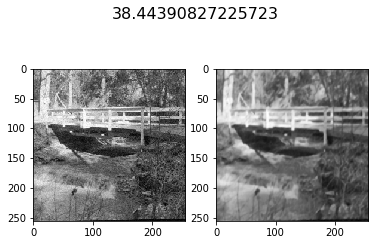

In [21]:
quality=psnr(filters.gaussian(test),reconstruction_test)

plt.subplot(1,2,1), plt.imshow(test,cmap=cm.gray)
plt.subplot(1,2,2), plt.imshow(reconstruction_test,cmap=cm.gray)
plt.suptitle(quality, size=16)


# 3. How about color images?

Here we take a simple approach by treating one channel at a time.

In [22]:
#Load a color image images and add Gaussian noise

cimg = io.imread('images/lena_coloured.png')

cimg = img_as_float( (cimg))
mean =0
var = 0.075 
cdis = util.random_noise(cimg, mean=mean, var=var)
# extract the three channels
red = cdis[:, :, 0]
green = cdis[:, :, 1]
blue = cdis[:, :, 2]

height, width = red.shape


In [23]:
# RECONSTRUCT RED CHANNEL 

K=200 
patch_size=(7, 7) 
non_zero_c = 2

data = extract_patches_2d(red, patch_size)
data = data.reshape(data.shape[0], -1) 
intercept = np.mean(data, axis=0) 
data -= intercept 

dico.set_params(\
                transform_algorithm = 'omp',\
                **{'transform_n_nonzero_coefs': non_zero_c}\
                ) 
code = dico.transform(data) 
patches = np.dot(code, atoms)

patches += intercept #denormalize
patches = patches.reshape(len(data), *patch_size)
rec_red = reconstruct_from_patches_2d(patches, (height, width))

# RECONSTRUCT GREEN CHANNEL 


data = extract_patches_2d(green, patch_size)
data = data.reshape(data.shape[0], -1) 
intercept = np.mean(data, axis=0) 
data -= intercept 

dico.set_params(\
                transform_algorithm = 'omp',\
                **{'transform_n_nonzero_coefs': non_zero_c}\
                ) 
code = dico.transform(data) 
patches = np.dot(code, atoms)

patches += intercept #denormalize
patches = patches.reshape(len(data), *patch_size)
rec_green = reconstruct_from_patches_2d(patches, (height, width))

# RECONSTRUCT BLUE CHANNEL 

data = extract_patches_2d(blue, patch_size)
data = data.reshape(data.shape[0], -1) 
intercept = np.mean(data, axis=0) 
data -= intercept 

dico.set_params(\
                transform_algorithm = 'omp',\
                **{'transform_n_nonzero_coefs': non_zero_c}\
                ) 
code = dico.transform(data) 
patches = np.dot(code, atoms)

patches += intercept #denormalize
patches = patches.reshape(len(data), *patch_size)
rec_blue = reconstruct_from_patches_2d(patches, (height, width))


In [24]:
reconstruction=cdis.copy()
reconstruction[:,:,0]=rec_red
reconstruction[:,:,1]=rec_green
reconstruction[:,:,2]=rec_blue

reconstruction.shape

(512, 512, 3)

Text(0.5, 0.98, '27.1176704047799')

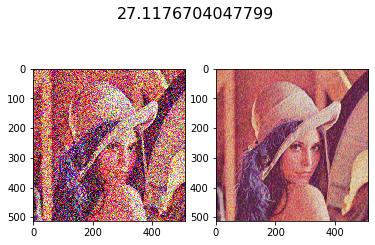

In [25]:
# Evaluate the reconstruction formula
def psnr_rgb(original_image, approximation_image):
    return 20*log10(np.amax(original_image)) - 10*log10(pow(np.linalg.norm(original_image - approximation_image), 2)
                                                        / (3* approximation_image.size))

quality=psnr_rgb(cimg,reconstruction)

plt.subplot(1,2,1), plt.imshow(cdis)
plt.subplot(1,2,2), plt.imshow(reconstruction)
plt.suptitle(quality, size=16)


# 4. Inpainting (sketch)

Below we artificially delete a portion of the data, you may control the quantity by changing the value of variable <tt> keep </tt>. 


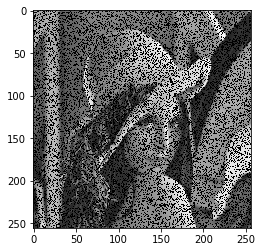

In [26]:
lena = io.imread('images/lena_color_256.tif')
lena = img_as_float(color.rgb2gray(lena))
keep = 0.7  # Keep 30% of the original data
random_mask = np.random.rand(*lena.shape) < keep
lena_rnd = lena*random_mask
plt.imshow(lena_rnd, cmap='gray')

You may first try applying the previous procedure and you should notice unsatisfactory results. 
The reason is that the noise we need to deal with is unhomogeneous and, for this reason, we should implement a modified weigthed version of KSVD (see <a href="https://elad.cs.technion.ac.il/wp-content/uploads/2018/02/KSVD_Color_IEEE_TIP.pdf"> Sparse Representation for Color Image Restoration </a> for more details. 

In this last part of this notebook you may reason on ways for modifying the above procedure in order to approximate this weighted version. One idea would be to divide in two parts the reconstruction of the image parts and the hole parts, of course still using the same pre-trained dictionary.

This would require re-implementing the patch extraction and reconstruction function, mainly.

